#  Quant Portfolio: Backtesting

By Joe Osborne: joe.osborne1337@gmail.com

Some of the techniques I use are from Hilpisch's Python for Finance: Mastering Data-Driven Finance 2nd Ed

## Data retrival

First, we must import libraries...

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

... and style our plots

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

Second, we must retrive the financial data. (From Hilpisch for now).

In [3]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [4]:
raw.info()

data = (pd.DataFrame(raw).dropna());
symbols = list(raw)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


## Mean Reversion Strategy

This strategy uses a short term and long term moving average. The long term moving average lags the short term moving average. When they cross over, it indicates a change in trend.

When the short-term moving average rises through the long-term this indicates a bullish phase and when the short-term moving average slips below the long-term moving average this indicates a bearish phase.

This strategy ignores:
- Transactional costs
- Portfolio composition and optimization
    - Diversity
    - Risky and risk-less asset composition
    - Initial equity and leverage ratio

In [5]:
MAs = {'2mo': 42, '12mo': 252}; # in days
symbol = symbols[0];

for MA in MAs:
    data[symbol+'_MA_'+MA] = data[symbol].rolling(MAs[MA]).mean()        
data.dropna(inplace=True)

In [6]:
data.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD,AAPL.O_MA_2mo,AAPL.O_MA_12mo
Date,,,,,,,,,,,,,,
2010-12-31,46.079954,27.9100,21.03,180.00,168.16,125.75,1257.64,17.75,1.3377,1419.45,61.47,138.72,45.280967,37.120735
2011-01-03,47.081381,27.9800,20.85,184.22,173.05,127.05,1271.87,17.61,1.3351,1413.80,60.77,138.00,45.349708,37.186246
2011-01-04,47.327096,28.0875,21.15,185.01,173.08,126.98,1270.20,17.38,1.3301,1380.21,59.02,134.75,45.412599,37.252521
2011-01-05,47.714238,28.0000,20.94,187.42,174.00,127.64,1276.56,17.02,1.3151,1376.80,58.22,134.37,45.466102,37.322266
2011-01-06,47.675667,28.8200,20.77,185.86,172.21,127.39,1273.85,17.40,1.3001,1371.00,56.74,133.83,45.522565,37.392079


In [7]:
MA_symbols = [symbol,symbol+'_MA_'+'2mo',symbol+'_MA_12mo'];

#Buy when short term moving average is > long term, sell vice versa
data[symbol+'_Position'] = np.where(data[symbol+'_MA_'+'2mo'] > data[symbol+'_MA_'+'12mo'], 1, -1)

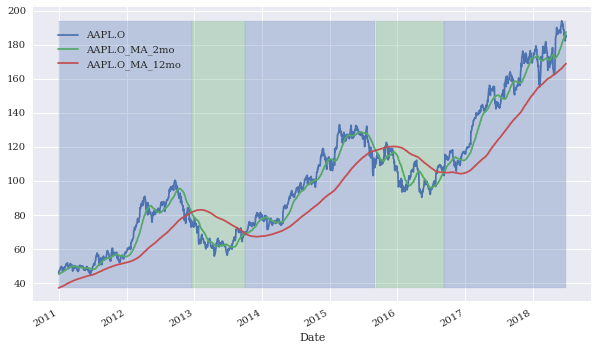

In [8]:
#Without position plotted
ax = data[MA_symbols].plot(figsize=(10, 6))

#With position plotted
#ax = data.plot( secondary_y=symbol+'_Position', figsize=(10, 6))

ax.get_legend().set_bbox_to_anchor((0.28, 0.95));

#Shade between moving averages
#ax.fill_between(data.index, data[symbol+'_MA_'+'2mo'].values, data[symbol+'_MA_'+'12mo'].values,\
#                 where=(data[symbol+'_MA_'+'2mo'].values > data[symbol+'_MA_'+'12mo'].values), color='C0', alpha=0.3)
#ax.fill_between(data.index, data[symbol+'_MA_'+'2mo'].values, data[symbol+'_MA_'+'12mo'].values,\
#                 where=(data[symbol+'_MA_'+'2mo'].values < data[symbol+'_MA_'+'12mo'].values), color='C1', alpha=0.3)

#Shade whole figure
min = data[MA_symbols].min().min()
max = data[MA_symbols].max().max()
ax.fill_between(data.index, min, max,where=(data[symbol+'_MA_'+'2mo'].values > data[symbol+'_MA_'+'12mo'].values),\
                color='C0', alpha=0.3)
ax.fill_between(data.index, min, max,where=(data[symbol+'_MA_'+'2mo'].values < data[symbol+'_MA_'+'12mo'].values),\
                color='C1', alpha=0.3)

In [9]:
data[symbol+'_Returns'] = np.log(data[symbol] / data[symbol].shift(1))  

In [10]:
data.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD,AAPL.O_MA_2mo,AAPL.O_MA_12mo,AAPL.O_Position,AAPL.O_Returns
Date,,,,,,,,,,,,,,,,
2010-12-31,46.079954,27.9100,21.03,180.00,168.16,125.75,1257.64,17.75,1.3377,1419.45,61.47,138.72,45.280967,37.120735,1,NaN
2011-01-03,47.081381,27.9800,20.85,184.22,173.05,127.05,1271.87,17.61,1.3351,1413.80,60.77,138.00,45.349708,37.186246,1,0.021500
2011-01-04,47.327096,28.0875,21.15,185.01,173.08,126.98,1270.20,17.38,1.3301,1380.21,59.02,134.75,45.412599,37.252521,1,0.005205
2011-01-05,47.714238,28.0000,20.94,187.42,174.00,127.64,1276.56,17.02,1.3151,1376.80,58.22,134.37,45.466102,37.322266,1,0.008147
2011-01-06,47.675667,28.8200,20.77,185.86,172.21,127.39,1273.85,17.40,1.3001,1371.00,56.74,133.83,45.522565,37.392079,1,-0.000809


In [11]:
data[symbol+'_Strategy'] = data[symbol+'_Position'].shift(1) * data[symbol+'_Returns']
data.dropna(inplace=True)

The performance of the moving average strategy is better than a long only strategy.

In [12]:
np.exp(data[[symbol+'_Returns',symbol+'_Strategy']].sum())  

AAPL.O_Returns     4.017148
AAPL.O_Strategy    5.811299
dtype: float64

### For all symbols

In [13]:
MeanRevResults = pd.DataFrame()
for symbol in symbols:
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(MAs['2mo']).mean()
    data['SMA2'] = data[symbol].rolling(MAs['12mo']).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    benchm = perf['Strategy'] - perf['Returns'];
    MeanRevResults = MeanRevResults.append(pd.DataFrame(
                {'Symbol':  symbol ,'SMA1': MAs['2mo'], 'SMA2': MAs['12mo'],
                 'MARKET': perf['Returns'],
                 'STRATEGY': perf['Strategy'],
                 'BENCHMARK': benchm},
                 index=[0]), ignore_index=True)  

In [14]:
MeanRevResults

,Symbol,SMA1,SMA2,MARKET,STRATEGY,BENCHMARK
0,AAPL.O,42,252,4.017148,5.811299,1.794151
1,MSFT.O,42,252,3.533142,0.787798,-2.745344
2,INTC.O,42,252,2.363766,0.549313,-1.814453
3,AMZN.O,42,252,9.443333,3.462586,-5.980747
4,GS.N,42,252,1.311667,1.200371,-0.111297
5,SPY,42,252,2.157296,1.296339,-0.860958
6,.SPX,42,252,2.161485,1.394976,-0.766509
7,.VIX,42,252,0.906479,0.000269,-0.906210
8,EUR=,42,252,0.890608,1.370496,0.479888
9,XAU=,42,252,0.904642,1.099720,0.195079


Very poor performance per unit per stock. Perhaps this can be improved through optimization

In [15]:
MeanRevResults['BENCHMARK'].sum()

-10.292299091699832

### Optimize SMA1 and SMA2

In [16]:
from itertools import product

In [17]:
sma1 = range(20, 61, 4)  
sma2 = range(180, 281, 10) 

In [18]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):
    MeanRevResults = pd.DataFrame()
    for symbol in symbols:
        data = pd.DataFrame(raw[symbol])
        data.dropna(inplace=True)
        data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
        data['SMA1'] = data[symbol].rolling(SMA1).mean()
        data['SMA2'] = data[symbol].rolling(SMA2).mean()
        data.dropna(inplace=True)
        data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['Strategy'] = data['Position'].shift(1) * data['Returns']
        data.dropna(inplace=True)
        perf = np.exp(data[['Returns', 'Strategy']].sum())
        benchm = perf['Strategy'] - perf['Returns'];
        MeanRevResults = MeanRevResults.append(pd.DataFrame(
                    {'Symbol':  symbol ,'SMA1': SMA1, 'SMA2': SMA2,
                     'MARKET': perf['Returns'],
                     'STRATEGY': perf['Strategy'],
                     'BENCHMARK': benchm},
                     index=[0]), ignore_index=True) 
    Sum_Bench = MeanRevResults['BENCHMARK'].sum()
    results = results.append(pd.DataFrame({'SMA1': SMA1, 'SMA2': SMA2,
                     'SUM_BENCHMARK': Sum_Bench},
                     index=[0]), ignore_index=True)

Even with (brute force) optimization, the best strategy looses money for all stocks when considering all stocks

In [19]:
results.sort_values('SUM_BENCHMARK', ascending=False).head(7)

,SMA1,SMA2,SUM_BENCHMARK
5,20,230,-8.070165
14,24,210,-8.394682
6,20,240,-9.160755
120,60,280,-9.214176
39,32,240,-9.348413
7,20,250,-9.404732
25,28,210,-9.471894
